## Assignment 06 - Submitted By

**Muhammad Raaid Khan**

**DS & AI**

**Batch-05**

# Task

Building **ResNet152V2** Model for Image Classification with Small Dataset 

**Number of classes**: 20 (Classes 0-19)
**Classes** = owl | galaxy | lightning | wine-bottle | t-shirt | waterfall | sword | school-bus | calculator | sheet-music | airplanes | lightbulb | skyscraper | mountain-bike | fireworks | computer-monitor | bear | grand-piano | kangaroo | laptop ]

**Dataset Structure**
Two folders:
Training: 1554 images
Test: 500 images

**Dataset Link**
https://github.com/miladfa7/Image-Classification-Transfer-Learning/tree/master/Dataset

### Suppressing Tensorflow Warnings

In [150]:
import os
import warnings
warnings.filterwarnings('ignore')

# Suppress TensorFlow warnings
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

### Using On-Machine GPU

In [173]:
from tensorflow.python.client import device_lib

# List physical GPU devices
gpus = tf.config.list_physical_devices('GPU')

if gpus:
    print(f"Number of GPUs available: {len(gpus)}\n")
    for i, gpu in enumerate(gpus):
        print(f"GPU {i}:")
        print(f"Name: {gpu.name}")
        print(f"Device Type: {gpu.device_type}")
        
        # Get detailed device info
        gpu_details = device_lib.list_local_devices()
        for device in gpu_details:
            if device.device_type == 'GPU':
                print(f"Device Description: {device.physical_device_desc}")
                print(f"Memory Limit: {device.memory_limit / (1024 ** 3):.2f} GB\n")
else:
    print("No GPU available")

Number of GPUs available: 1

GPU 0:
Name: /physical_device:GPU:0
Device Type: GPU
Device Description: device: 0, name: NVIDIA GeForce RTX 3060 Laptop GPU, pci bus id: 0000:01:00.0, compute capability: 8.6
Memory Limit: 3.50 GB



### Importing Necessary Libraries

In [151]:
import tensorflow as tf
import numpy as np
import os

In [152]:
import zipfile
zip = zipfile.ZipFile("/tf/Image-Classification-Transfer-Learning/Dataset.zip",'r')
zip.extractall("/tf/Image-Classification-Transfer-Learning/Dataset")
zip.close()

In [153]:
dataset_dir = os.path.join('/tf/Image-Classification-Transfer-Learning/Dataset/')

In [154]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator


data_gen = ImageDataGenerator(rotation_range=50,
                                    width_shift_range=0.2,
                                    height_shift_range=0.2,
                                    zoom_range=0.3,
                                    horizontal_flip=True,
                                    vertical_flip=True,
                                    fill_mode='constant',
                                    cval=0,
                                    rescale=1./255,
                                    validation_split=0.2  # Reserve 20% of the data for validation
                                    )


In [155]:
# Directory where your validation data is stored
valid_dir = os.path.join(dataset_dir, 'valid')

In [156]:
Batch_size = 8
img_h = 256
img_w = 256
num_classes=20

classes = ['owl', # 0
            'galaxy', # 1
            'lightning', # 2
            'wine-bottle', # 3
            't-shirt', # 4
            'waterfall',# 5
            'sword', # 6
            'school-bus',# 7           
            'calculator', # 8
            'sheet-music', #9            
            'airplanes',#10      
            'lightbulb', # 11
            'skyscraper',#12    
            'mountain-bike',#13          
            'fireworks', #14        
            'computer-monitor',#15              
            'bear',# 16
            'grand-piano', # 17
            'kangaroo', # 18
            'laptop', #19
           ]

In [157]:
# Training
SEED = 1234
tf.random.set_seed(SEED) 

training_dir = os.path.join(dataset_dir, 'training')
train_gen = data_gen.flow_from_directory(training_dir,
                                        target_size=(256, 256),
                                        batch_size=Batch_size,
                                        classes=classes,
                                        class_mode='categorical',
                                        shuffle=True,
                                        subset='training',  # Use only the training portion
                                        seed=SEED)  # targets are directly converted into one-hot vectors

# Validation
valid_gen = data_gen.flow_from_directory(training_dir,
                                        target_size=(256, 256),
                                        batch_size=Batch_size, 
                                        classes=classes,
                                        class_mode='categorical',
                                        shuffle=False,
                                        subset='validation',  # Use the validation portion
                                        seed=SEED)

Found 1247 images belonging to 20 classes.
Found 307 images belonging to 20 classes.


## Visualizing Data

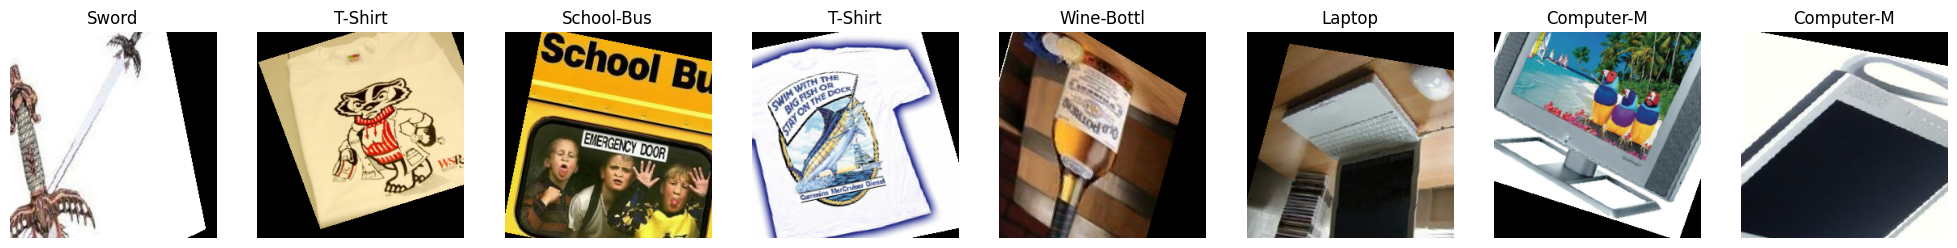

In [158]:
CLASS_NAMES = np.array(['owl','galaxy', 'lightning','wine-bottle','t-shirt','waterfall', 'sword', 'school-bus',
                        'calculator','sheet-music','airplanes', 'lightbulb', 'skyscraper','mountain-bike','fireworks', 
                        'computer-monitor','bear','grand-piano','kangaroo','laptop',], dtype='<U10')

import matplotlib.pyplot as plt

def show_batch(image_batch, label_batch):
  plt.figure(figsize=(25,20))
  for n in range(8):
      ax = plt.subplot(1,8,n+1)
      plt.imshow(image_batch[n])
      plt.title(CLASS_NAMES[label_batch[n]==1][0].title())
      plt.axis('off')
      
image_batch, label_batch = next(train_gen)
show_batch(image_batch, label_batch)

## Getting ResNet Model

In [159]:
ResNet_model = tf.keras.applications.ResNet152V2(weights='imagenet', include_top=False, input_shape=(img_h, img_w, 3))

## Building Model

In [175]:
from tensorflow.keras import Model 
from tensorflow.keras.layers import Conv2D, Dense, MaxPooling2D, Dropout, Flatten,GlobalAveragePooling2D
from tensorflow.keras.models import Sequential

# The last 15 layers fine tune
for layer in ResNet_model.layers[:-15]:
    layer.trainable = False

x = ResNet_model.output
x = GlobalAveragePooling2D()(x)
x = Flatten()(x)
x = Dense(units=512, activation='relu')(x)
x = Dropout(0.3)(x)
x = Dense(units=512, activation='relu')(x)
x = Dropout(0.3)(x)
output  = Dense(units=20, activation='softmax')(x)
model = Model(ResNet_model.input, output)


In [161]:
loss = tf.keras.losses.CategoricalCrossentropy()
optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)
model.compile(optimizer=optimizer, loss=loss, metrics= ['accuracy'])

In [162]:
STEP_SIZE_TRAIN=train_gen.n//train_gen.batch_size
STEP_SIZE_VALID=valid_gen.n//valid_gen.batch_size
transfer_learning_history = model.fit_generator(generator=train_gen,
                   steps_per_epoch=STEP_SIZE_TRAIN,
                   validation_data=valid_gen,
                   validation_steps=STEP_SIZE_VALID,
                   epochs=20,       
)


Epoch 1/20
155/155 [==============================] - 28s 116ms/step - loss: 1.5425 - accuracy: 0.5811 - val_loss: 3.7060 - val_accuracy: 0.7237
Epoch 2/20
155/155 [==============================] - 15s 98ms/step - loss: 1.0507 - accuracy: 0.7417 - val_loss: 1.0842 - val_accuracy: 0.7763
Epoch 3/20
155/155 [==============================] - 15s 99ms/step - loss: 0.7430 - accuracy: 0.8111 - val_loss: 0.8066 - val_accuracy: 0.8059
Epoch 4/20
155/155 [==============================] - 15s 98ms/step - loss: 0.6485 - accuracy: 0.8313 - val_loss: 0.6108 - val_accuracy: 0.8355
Epoch 5/20
155/155 [==============================] - 16s 100ms/step - loss: 0.5288 - accuracy: 0.8499 - val_loss: 0.6217 - val_accuracy: 0.8520
Epoch 6/20
155/155 [==============================] - 17s 108ms/step - loss: 0.4496 - accuracy: 0.8757 - val_loss: 0.6264 - val_accuracy: 0.8553
Epoch 7/20
155/155 [==============================] - 17s 110ms/step - loss: 0.4161 - accuracy: 0.8862 - val_loss: 0.3740 - val_accur

## Visualizing Model Accuracy and Loss

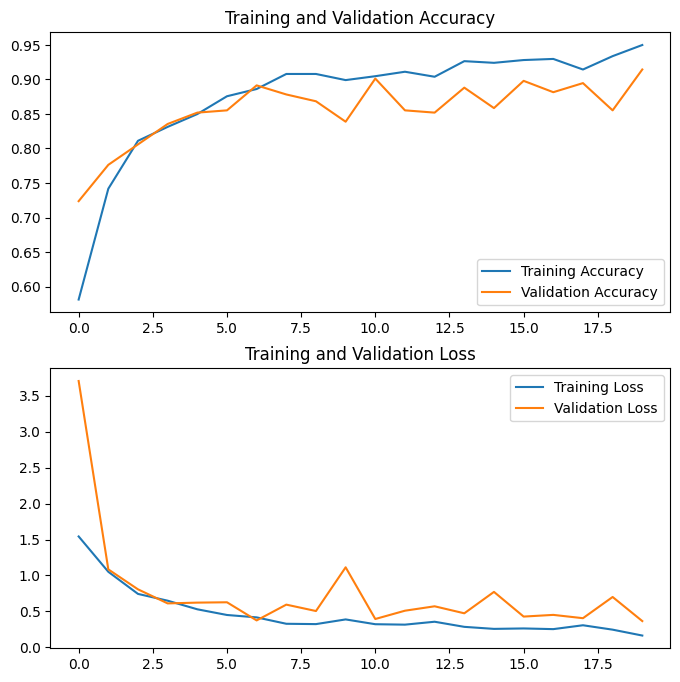

In [163]:
import matplotlib.pyplot as plt

acc = transfer_learning_history.history['accuracy']
val_acc = transfer_learning_history.history['val_accuracy']

loss = transfer_learning_history.history['loss']
val_loss = transfer_learning_history.history['val_loss']

epochs_range = range(20)

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [164]:
model.evaluate(valid_gen, steps=STEP_SIZE_VALID,verbose=1)

38/38 [==============================] - 3s 83ms/step - loss: 0.4971 - accuracy: 0.8750


[0.49708300828933716, 0.875]

## Making Predictions on Un-Seen Images

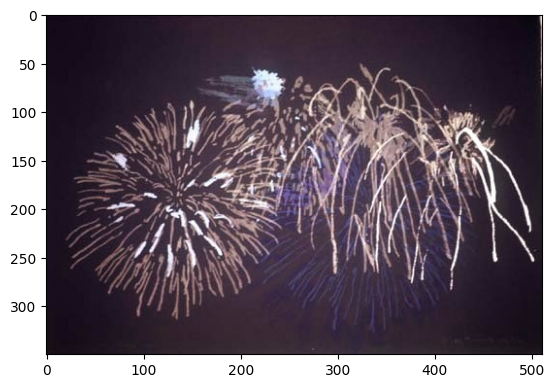

In [165]:
import cv2
from tensorflow.keras.preprocessing import image

# Path to the new images
new_image_path = '/tf/Test Pics/fw.jpg'

# Load the image
img = image.load_img(new_image_path, target_size=(256, 256))  # Ensure the image is resized to the model's expected input size

# Preprocess the image (convert to array and scale it)
img_array = image.img_to_array(img)
img_array = np.expand_dims(img_array, axis=0)  # Add batch dimension (1, height, width, channels)
img_array = img_array / 255.0  # Normalize the pixel values (same as you did during training)

test_img = cv2.imread(new_image_path)
plt.imshow(test_img)

In [166]:
# Make predictions
predictions = model.predict(img_array)

# Get the predicted class index
predicted_class_index = np.argmax(predictions, axis=1)

# If you have class names, map the index to the corresponding class label
class_names = classes  # Replace with your actual class names
predicted_class = class_names[predicted_class_index[0]]

# Output the predicted class
print(f"Predicted class: {predicted_class}")

1/1 [==============================] - 2s 2s/step
Predicted class: fireworks


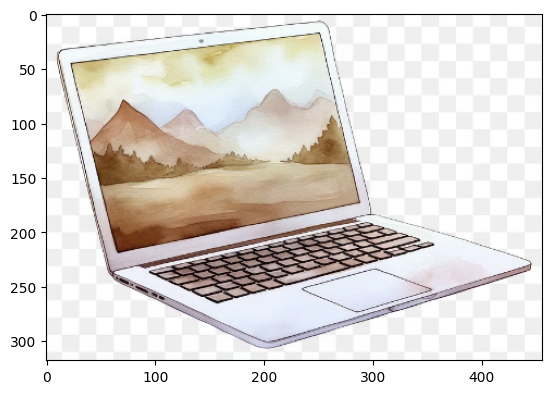

In [169]:
import cv2
from tensorflow.keras.preprocessing import image

# Path to the new images
new_image_path = '/tf/Test Pics/laptop.png'

# Load the image
img = image.load_img(new_image_path, target_size=(256, 256))  # Ensure the image is resized to the model's expected input size

# Preprocess the image (convert to array and scale it)
img_array = image.img_to_array(img)
img_array = np.expand_dims(img_array, axis=0)  # Add batch dimension (1, height, width, channels)
img_array = img_array / 255.0  # Normalize the pixel values (same as you did during training)

test_img = cv2.imread(new_image_path)
plt.imshow(test_img)

In [170]:
# Make predictions
predictions = model.predict(img_array)

# Get the predicted class index
predicted_class_index = np.argmax(predictions, axis=1)

# If you have class names, map the index to the corresponding class label
class_names = classes  # Replace with your actual class names
predicted_class = class_names[predicted_class_index[0]]

# Output the predicted class
print(f"Predicted class: {predicted_class}")

1/1 [==============================] - 0s 62ms/step
Predicted class: laptop


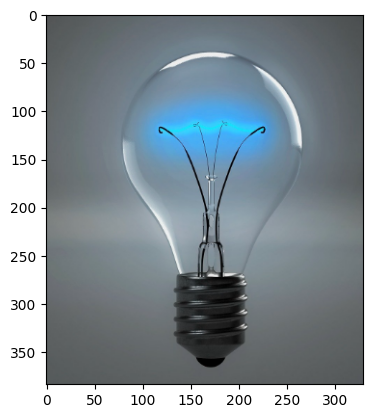

In [171]:
import cv2
from tensorflow.keras.preprocessing import image

# Path to the new images
new_image_path = '/tf/Test Pics/bulb.png'

# Load the image
img = image.load_img(new_image_path, target_size=(256, 256))  # Ensure the image is resized to the model's expected input size

# Preprocess the image (convert to array and scale it)
img_array = image.img_to_array(img)
img_array = np.expand_dims(img_array, axis=0)  # Add batch dimension (1, height, width, channels)
img_array = img_array / 255.0  # Normalize the pixel values (same as you did during training)

test_img = cv2.imread(new_image_path)
plt.imshow(test_img)

In [172]:
# Make predictions
predictions = model.predict(img_array)

# Get the predicted class index
predicted_class_index = np.argmax(predictions, axis=1)

# If you have class names, map the index to the corresponding class label
class_names = classes  # Replace with your actual class names
predicted_class = class_names[predicted_class_index[0]]

# Output the predicted class
print(f"Predicted class: {predicted_class}")

1/1 [==============================] - 0s 49ms/step
Predicted class: lightbulb
